In [2]:
!pip install contractions
!pip install beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.8 MB/s eta 0:00:00


In [2]:
import pandas as pd

df = pd.read_csv('./IMDB-Dataset.csv')
df = df.drop_duplicates()

In [3]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions


stop = set(stopwords.words('english'))

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()

    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Expand contractions
    text = expand_contractions(text)

    # Remove emojis
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub (r'\.(?=\ S)', '. ',text )
    text = re.sub(r'http\S+', '', text)
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])
    return text

df['review'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-3-0b0c6f96909d>:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


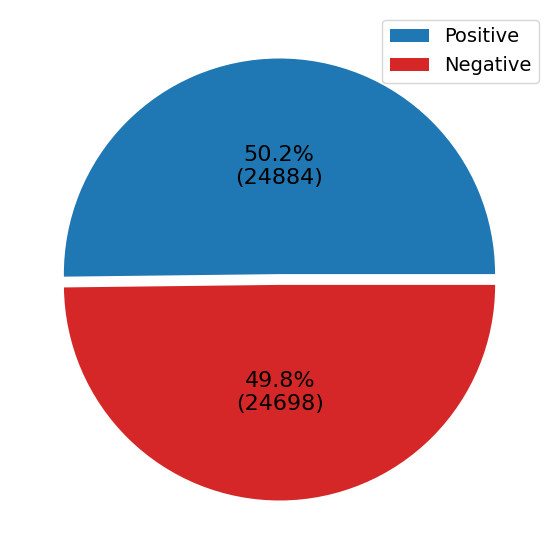

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return '{:.1f}%\n({:d})'.format(pct, absolute)

# Get frequencies of positive and negative sentiments
freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['Positive', 'Negative']

fig, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.025]*2,
        pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})

plt.legend(labels, loc='best', prop={'size': 14})
fig.savefig('PieChart.png')
plt.show()

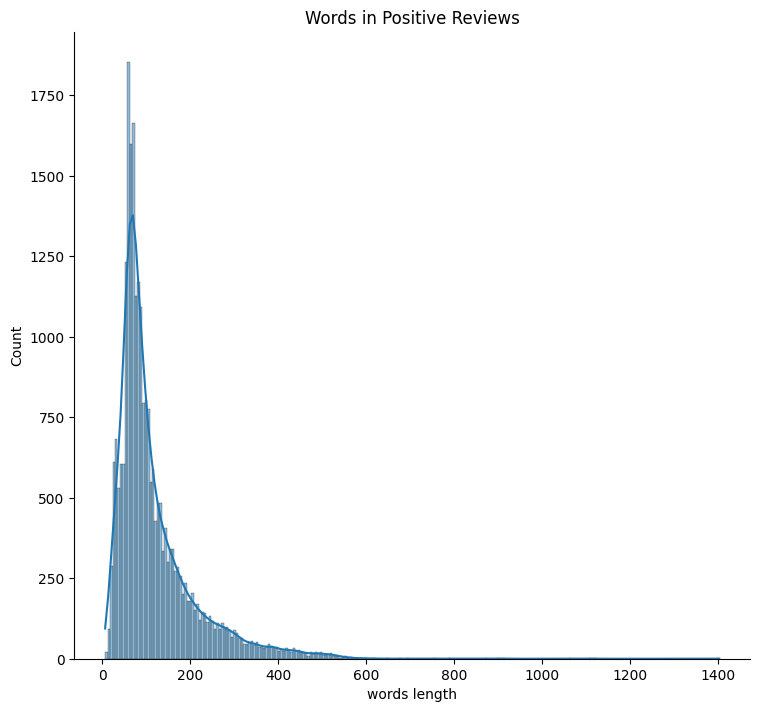

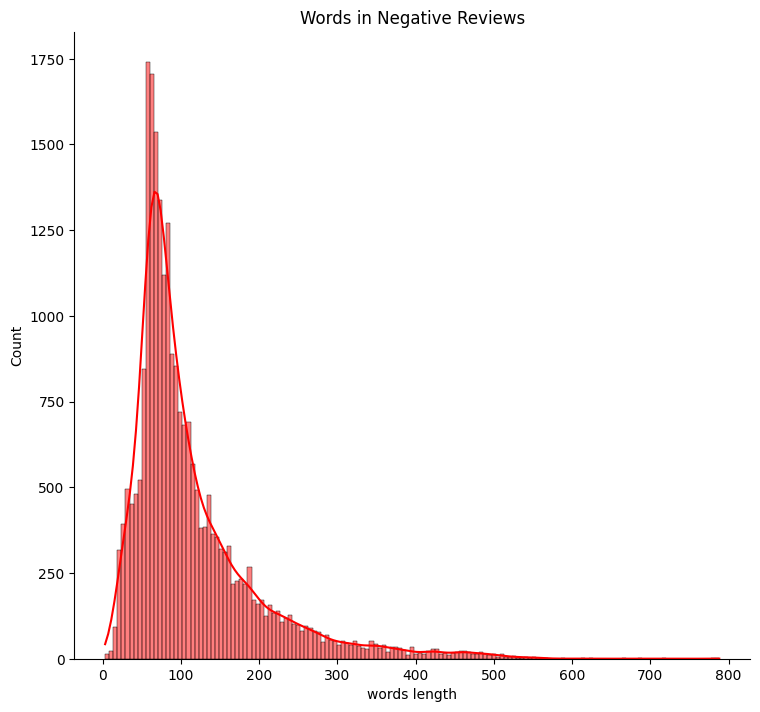

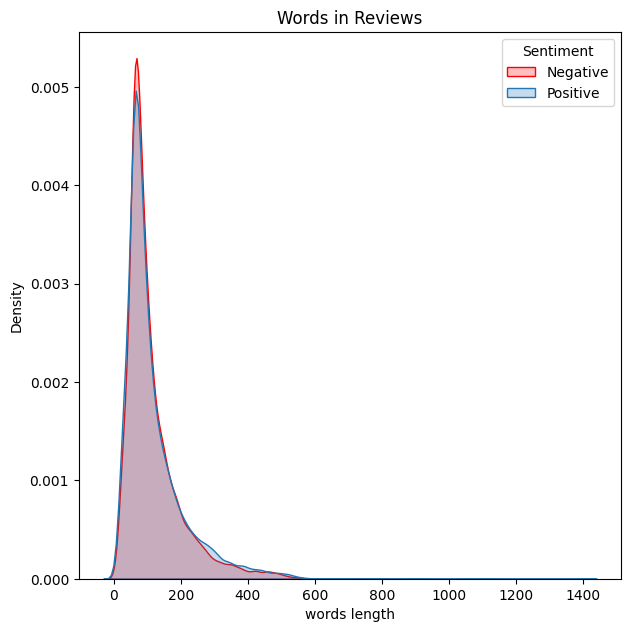

In [5]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x='words length', hue='sentiment', kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in Positive Reviews')
plt.show()

hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x='words length', hue='sentiment', kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in Negative Reviews')
plt.show()

plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x='words length', hue='sentiment', fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in Reviews')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.show(kernel_distribution_number_words_plot)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])
x_data = df['review']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train)
x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy of Decision Tree Classifier: {accuracy:.2f}')

Accuracy of Decision Tree Classifier: 0.71


In [9]:
rc_classifier = RandomForestClassifier(random_state=42)
rc_classifier.fit(x_train_encoded, y_train)
y_pred = rc_classifier.predict(x_test_encoded)
accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy of Decision Tree Classifier: {accuracy:.2f}')

Accuracy of Decision Tree Classifier: 0.84
